# Project 5: Machine Learning Modelling to Predict Deaths Associated with COVID-19

### Part 3: Model Testing

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

import os
import glob

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics

%matplotlib inline

#### Preprocessing

In [3]:
# importing cleaned texas covid-19 data into a dataframe
df_texas = pd.read_csv('../data/texas_clean_csv.csv',
                 na_values=[''], keep_default_na=False)

In [4]:
# checking for missing values
df_texas.isnull().sum(0)

province_state           0
confirmed                0
deaths                   0
recovered                0
active                   0
fips                     0
incident_rate            0
people_tested           52
mortality_rate          52
uid                      0
testing_rate             0
total_test_results     132
case_fatality_ratio    132
dtype: int64

In [5]:
# dropped columns with missing values. could imputate people_tested/mortality_rate, but mortality rate
# feels like a give away considering deaths are our outcome of interest, and people_tested is associated with testing_rate
X = df_texas.drop(columns=['deaths', 'province_state', 
                     'fips', 'uid', 
                     'case_fatality_ratio', 'mortality_rate',
                     'people_tested', 'total_test_results']) 
y = df_texas['deaths']

In [6]:
X.head()

,confirmed,recovered,active,incident_rate,testing_rate
0,196377,100843.0,91461.0,672.274797,7357.793336
1,192796,97430.0,92116.0,662.690677,7145.183828
2,429579,260542.0,161245.0,1476.861489,12448.230147
3,263551,132638.0,126908.0,906.204574,8596.924508
4,270707,136419.0,130083.0,930.401115,8760.295988


#### Model 1: Null Model

In [7]:
# Mean deaths
df_texas['deaths'].mean()

15338.282608695652

In [8]:
# Define y
y = df_texas['deaths']

# Create a new column for the baseline target variable
df_texas['null_deaths'] = y.mean()

# Predictions for the null model
y_preds = df_texas['null_deaths']

# Null R-squared
metrics.r2_score(y, y_preds)

0.0

In [9]:
# Null RMSE
np.sqrt(metrics.mean_squared_error(y_true=y, y_pred=y_preds))

6936.424369142072

In [10]:
X = df_texas.drop(columns=['deaths', 'province_state', 
                     'fips', 'uid', 
                     'case_fatality_ratio', 'mortality_rate',
                     'people_tested', 'total_test_results',
                     'null_deaths']) # Removed null_deaths which was created for null model
y = df_texas['deaths']

In [11]:
X.columns

Index(['confirmed', 'recovered', 'active', 'incident_rate', 'testing_rate'], dtype='object')

#### Model 2: Linear Regression

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
lr = LinearRegression()
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)
lr.fit(Z_train, y_train)
lr.score(Z_train, y_train), lr.score(Z_test, y_test)

(0.995648370687546, 0.9985647799342894)

In [13]:
lr_preds = lr.predict(Z_test)
np.sqrt(metrics.mean_squared_error(y_train, lr.predict(Z_train))), np.sqrt(metrics.mean_squared_error(y_test, lr_preds))

(455.7707680422825, 261.2977834895308)

In [14]:
print(dict(zip(X.columns, lr.coef_)))

{'confirmed': 8564.794386975827, 'recovered': -172837.36429458903, 'active': -36192.85602805677, 'incident_rate': 199989.75864526688, 'testing_rate': -1648.3269803989979}


####  PCA

In [15]:
ss = StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

In [16]:
pca = PCA(n_components=2)
pca.fit(Z_train)
pca.transform(Z_train)

array([[-0.46053952, -0.82373981],
       [-1.88346391,  0.69502531],
       [-0.66966596, -0.79587146],
       [ 0.26554559, -0.6116212 ],
       [-1.24368686, -0.31623252],
       [ 4.46795539,  0.34761805],
       [-1.97931476,  0.88191016],
       [ 2.18691792,  0.34620792],
       [-1.31210834,  0.024653  ],
       [ 2.91307221, -0.47327827],
       [ 2.79758869,  0.52200795],
       [-1.10582306, -0.64628344],
       [ 2.12787395,  0.39173151],
       [-2.22549064,  1.04166957],
       [ 4.63627016,  0.51951168],
       [ 2.86688108,  0.53433048],
       [-0.55800274, -0.81453773],
       [-1.18127131, -0.52508232],
       [-1.70044275,  0.56763925],
       [ 1.17238881, -0.35524471],
       [-3.25401345,  0.441657  ],
       [-0.28265754, -0.76420011],
       [-0.32376117, -0.79030856],
       [-0.5366011 , -0.81746075],
       [-2.33891255,  1.02354331],
       [ 4.38816769,  0.51632932],
       [ 0.42044502, -0.5424636 ],
       [-2.08686765,  0.99762253],
       [-2.08221174,

In [17]:
var_exp = pca.explained_variance_ratio_
var_exp

array([0.92677181, 0.07150961])

In [18]:
cum_var_exp = np.cumsum(var_exp)
cum_var_exp

array([0.92677181, 0.99828142])

PCA model was ran to observe the predictive capability of our model.
Ultimately, PCA does not offer interpretability, so we did not proceed with PCA

#### Model 3: Ridge Regression

In [19]:
# setting up ridge model and parameters
ridge_reg = Ridge()

params_ridge = {'alpha': [1,0.1,0.01,0.001,0.0001,0], 
                "fit_intercept": [True, False], 
                "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

In [20]:
# setting up X and y
X = df_texas.drop(columns=['deaths', 'province_state', 
                     'fips', 'uid', 
                     'case_fatality_ratio', 'mortality_rate',
                     'people_tested', 'total_test_results',
                     'null_deaths']) # Removed null_deaths which was created for null model
y = df_texas['deaths']

In [21]:
X.columns

Index(['confirmed', 'recovered', 'active', 'incident_rate', 'testing_rate'], dtype='object')

In [22]:
X.shape

(184, 5)

In [23]:
# train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [24]:
# performing our gridsearch
ridge_gs = GridSearchCV(ridge_reg, param_grid=params_ridge, n_jobs=-1)
ridge_gs.fit(X_train,y_train)
ridge_gs.best_params_

{'alpha': 1, 'fit_intercept': True, 'solver': 'lsqr'}

In [25]:
ridge_gs.best_score_

0.9904466613577471

In [26]:
# setting up ridge model with best paramters
ridge_reg = Ridge(alpha = 0.01, solver='lsqr')

In [27]:
# scaling the data
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

In [28]:
# fitting our data with the best paramters
ridge_reg.fit(Z_train, y_train)
ridge_reg.score(Z_train, y_train), ridge_reg.score(Z_test, y_test)

(0.9919204551916379, 0.9951482276251205)

In [29]:
# calculating predictions and RMSE
ridge_reg_preds = ridge_reg.predict(Z_test)
np.sqrt(metrics.mean_squared_error(y_train, ridge_reg.predict(Z_train))), np.sqrt(metrics.mean_squared_error(y_test, ridge_reg_preds))

(621.0319838241048, 480.42620227777957)

In [30]:
# evaluating coefficients
print(dict(zip(X.columns, ridge_reg.coef_)))

{'confirmed': 13189.337554293394, 'recovered': -1626.3541612302113, 'active': -2808.646648365356, 'incident_rate': -39.72158728365753, 'testing_rate': -2615.85387620089}


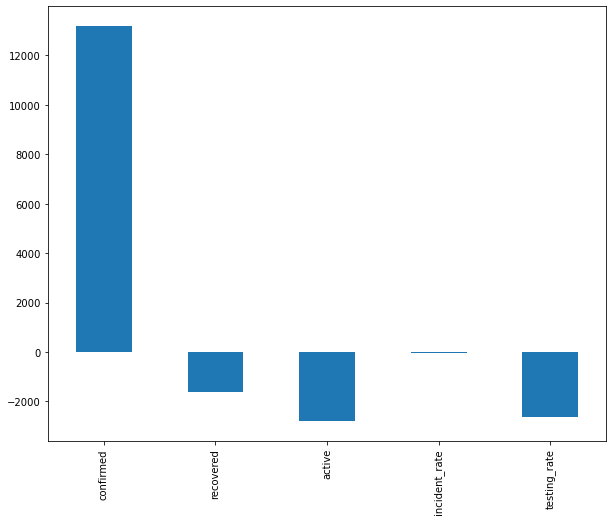

In [31]:
# visualizing coefficients
features = ['confirmed', 'recovered', 'active', 'incident_rate', 'testing_rate']
pd.Series(ridge_reg.coef_, index=features).plot.bar(figsize=(10, 8));

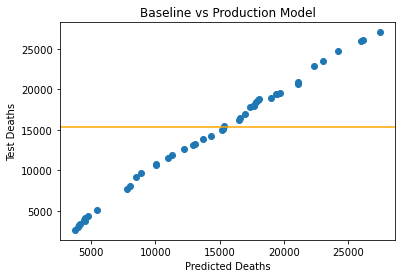

In [32]:
# comparing test values with model predicted values
plt.scatter(ridge_reg_preds, y_test)
plt.title('Baseline vs Production Model')
plt.ylabel('Test Deaths')
plt.xlabel('Predicted Deaths')
plt.axhline(df_texas['deaths'].mean(), color='orange');

**Interpretation:**
Our R-squared on unseen data is 99.5%, and our RMSE on unseen data is 480.43.

Because this model has the best values for our metrics of interest, we will use Ridge Regression as our production model

#### Model 4: Lasso Regression

In [33]:
# setting up lasso model
lasso_reg = Lasso()

In [34]:
# grid search parameters
params_lasso = {'alpha': [1,0.1,0.01,0.001,0.0001,0], 
                "fit_intercept": [True, False], 
                "selection": ['cyclic', 'random']}

In [35]:
# setting up X and y
X = df_texas.drop(columns=['deaths', 'province_state', 
                     'fips', 'uid', 
                     'case_fatality_ratio', 'mortality_rate',
                     'people_tested', 'total_test_results',
                     'null_deaths']) # Removed null_deaths which was created for null model
y = df_texas['deaths']

In [36]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [37]:
# performing gridsearch on lasso model
lasso_gs = GridSearchCV(lasso_reg, param_grid=params_lasso, n_jobs=-1)
lasso_gs.fit(X_train,y_train)
lasso_gs.best_params_

/Users/ericrodriguez/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.058e+07, tolerance: 5.186e+05
  model = cd_fast.enet_coordinate_descent(
/Users/ericrodriguez/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.304e+07, tolerance: 5.327e+05
  model = cd_fast.enet_coordinate_descent(
/Users/ericrodriguez/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider

{'alpha': 1, 'fit_intercept': True, 'selection': 'cyclic'}

In [38]:
lasso_gs.best_score_

0.991148026858958

In [39]:
# setting up lasso model with best parameters
lasso_reg = Lasso(alpha = 1, selection='cyclic')

In [40]:
# scaling the data
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

In [41]:
# fitting our data with the best parameters
lasso_reg.fit(Z_train, y_train)
lasso_reg.score(Z_train, y_train), lasso_reg.score(Z_test, y_test)

/Users/ericrodriguez/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.443e+07, tolerance: 6.587e+05
  model = cd_fast.enet_coordinate_descent(


(0.991730792800147, 0.9948596502742886)

In [42]:
# calculating predictions and RMSE
lasso_reg_preds = lasso_reg.predict(Z_test)
np.sqrt(metrics.mean_squared_error(y_train, lasso_reg.predict(Z_train))), np.sqrt(metrics.mean_squared_error(y_test, lasso_reg_preds))

(628.2788751455299, 494.50741790818734)

In [43]:
# evaluating lasso model coefficients
print(dict(zip(X.columns, lasso_reg.coef_)))

{'confirmed': 10846.483542898348, 'recovered': -1250.8800740937777, 'active': -2730.2334714928893, 'incident_rate': 803.1091806968639, 'testing_rate': -1548.7465694162004}


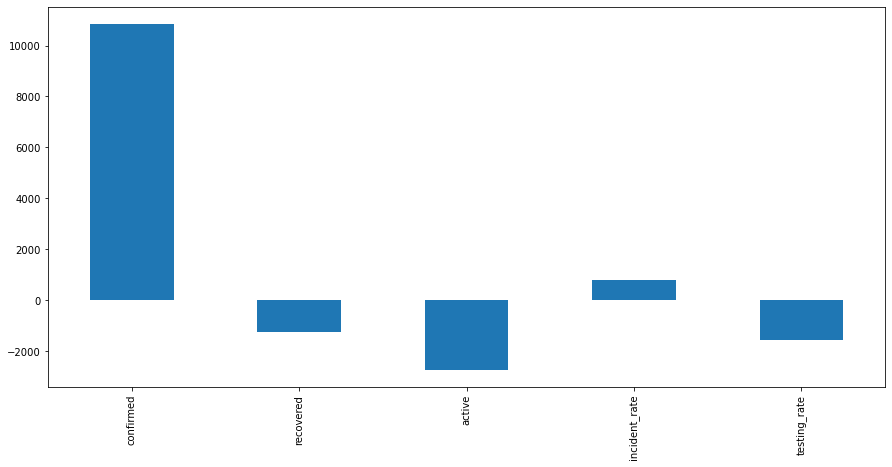

In [44]:
# visualizing coefficients
features = ['confirmed', 'recovered', 'active', 'incident_rate', 'testing_rate']
pd.Series(lasso_reg.coef_, index=features).plot.bar(figsize=(15, 7));

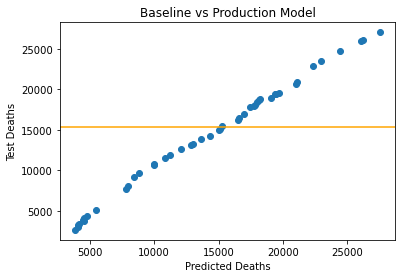

/Users/ericrodriguez/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.411e+07, tolerance: 5.393e+05
  model = cd_fast.enet_coordinate_descent(
/Users/ericrodriguez/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.350e+07, tolerance: 5.186e+05
  model = cd_fast.enet_coordinate_descent(
/Users/ericrodriguez/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider

In [45]:
# comparing test values with model predicted values
plt.scatter(lasso_reg_preds, y_test)
plt.title('Baseline vs Production Model')
plt.ylabel('Test Deaths')
plt.xlabel('Predicted Deaths')
plt.axhline(df_texas['deaths'].mean(), color='orange');

**Interpretation:**
Our R-squared on unseen data is 99.5%, and our RMSE on unseen data is 494.51